In [87]:
# this cell fetches and sets up the data - just run it

import os
import requests

genomes = ['a_thaliana_chr1.fasta', 'p_falciparum_chr1.fasta', 'e_coli.fasta', 'm_tuberculosis.fasta']
genome_names = ['A. thaliana', 'P. falciparum', 'E. coli', 'M. tuberculosis']

def gc_content(dna):
    g_count = dna.lower().count('g')
    c_count = dna.lower().count('c')
    gc_percentage = round((g_count + c_count) / len(dna) * 100, 2)
    return gc_percentage

def sample_genome(filename, length=10000):
    return ''.join(open(filename).read(length).split('\n')[1:])

def fetch(genomes):
    url_base = 'https://raw.githubusercontent.com/pvanheus/bitc2019_notebooks/master/gc/'
    try:
        os.mkdir('gc')
    except FileExistsError:
        pass  # we don't really care if the directory already exists
    for genome in genomes:
        url = url_base + genome
        filename = 'gc/' + genome
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, 'wb') as output_file:
                output_file.write(response.content)

def gc_per_chunk(data, chunksize=100):
    chunk_gc_percentages = []
    chunk_starts = []
    for i in range(0, len(data), chunksize):
        start = i
        chunk_starts.append(start)
        end = i + chunksize
        chunk = data[start:end]
        if chunk != '':
            chunk_gc_percentages.append(gc_content(chunk))
    return (chunk_gc_percentages, chunk_starts)

fetch(genomes)

gc_percentages = []
for i, genome in enumerate(genomes):
    filename = 'gc/' + genome
    data = sample_genome(filename)
    gc_perc = gc_content(data)
    print(genome_names[i], gc_perc)
    gc_percentages.append(gc_perc)

(tb_gc_percentages, chunk_starts) = gc_per_chunk(sample_genome('gc/m_tuberculosis.fasta'))

A. thaliana 34.15
P. falciparum 32.64
E. coli 52.06
M. tuberculosis 61.19


### Plotting in Python

There are *many* options for plotting in Python - this [graphic](https://github.com/rougier/python-visualization-landscape) summarises many of them as of 2017 (and now there is yet another: [hvplot](http://blog.pyviz.org/hvplot_announcement.html)). There is a rather verbose walkthrough of some of the alternatives [here](https://dsaber.com/2016/10/02/a-dramatic-tour-through-pythons-data-visualization-landscape-including-ggplot-and-altair/).

This notebook illustrates two of the options: Matplotlib and Altair.

#### Matplotlib

[Matplotlib](https://matplotlib.org/) is the "classic" plotting module for Python. In it you build up a plot by calling multiple functions and the result "stacks" together.

Text(0.5,0,'Species')

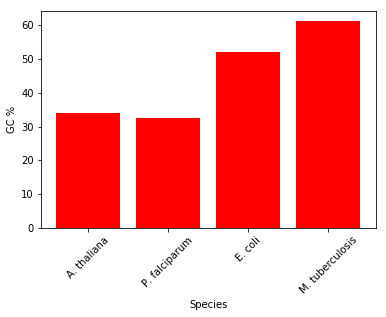

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(genome_names, gc_percentages, color='r')
plt.xticks(rotation=45)
plt.ylabel('GC %')
plt.xlabel('Species')

Text(0.5,1,'GC percentage by genome position')

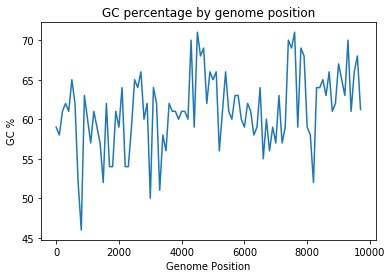

In [82]:
plt.plot(chunk_starts, tb_gc_percentages)
plt.ylabel('GC %')
plt.xlabel('Genome Position')
plt.title('GC percentage by genome position')

#### Altair

[Altair](https://altair-viz.github.io/index.html) is a newer plotting module that is designed to work well with Pandas and also web tools like Jupyter Lab and Jupyter Notebook.

Altair follows a "declarative" model of designing a plot: instead of saying what you are doing (like in Matplotlib) you tell Altair what your data is and how you would like your data to be associated with a chart. For example the X axis is from column `species` and the Y axis is from column `gc_content`. There is a nice but a little outdated tutorial [here](https://vallandingham.me/altair_intro.html).

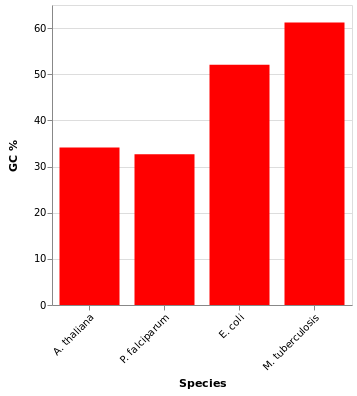

In [62]:
# altair is not a standard part of anaconda
# install with this command in the Terminal or Anaconda Prompt
# conda install -c conda-forge altair=2.4.1
import pandas as pd
import altair as alt

dataframe = pd.DataFrame({'species': genome_names, 'gc_content': gc_percentages})
# configure the chart data source, then the mark and its config, 
# then the encoding of data to chart elements and finally any chart configuration
alt.Chart(dataframe, width=300).mark_bar(color='red').encode(
    x=alt.X('species', sort=None, axis=alt.Axis(title='Species', labelAngle=-45)), 
    y=alt.Y('gc_content', axis=alt.Axis(title='GC %'))).configure_scale(bandPaddingInner=0.2)

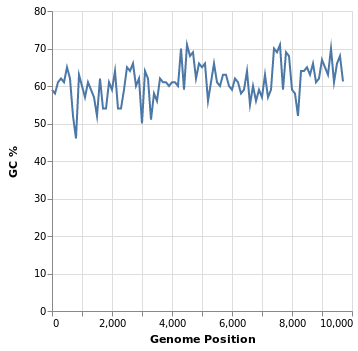

In [86]:
dataframe = pd.DataFrame({'position': chunk_starts, 'gc_percentage': tb_gc_percentages})
alt.Chart(dataframe, width=300).mark_line().encode(
    x=alt.X('position', axis=alt.Axis(title='Genome Position')),
    y=alt.Y('gc_percentage', axis=alt.Axis(title='GC %'))
)

As a package built on web-centric tools like Javascript and the D3 library, Altair charts can be dynamic, as this tooltip example illustrates

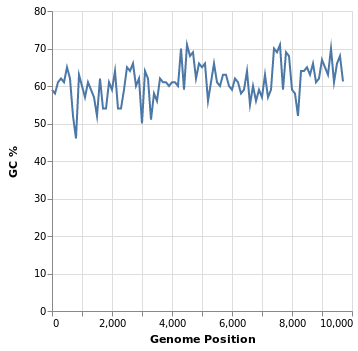

In [98]:
dataframe = pd.DataFrame({'position': chunk_starts, 'gc_percentage': tb_gc_percentages})
alt.Chart(dataframe, width=300).mark_line().encode(
    x=alt.X('position', axis=alt.Axis(title='Genome Position')),
    y=alt.Y('gc_percentage', axis=alt.Axis(title='GC %')), tooltip='gc_percentage'
)